# 분석 정리

1. Store : 쇼핑몰 지점
    - 원-핫 인코딩
2. Date : 주 단위(Weekly) 날짜
    - Year, Month 파생 변수 생성 후 Year만 원-핫 인코딩
3. Temperature : 해당 쇼핑몰 주변 기온
    - 4 구간으로 구간화
4. Fuel_Price : 해당 쇼핑몰 주변 연료 가격
    - 4 구간으로 구간화
5. Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보
    - 결측치는 -1로 채우고 4 구간으로 구간화
    - 차라리 0으로 채우고 4 구간화 하는 게 나았으려나?
6. Unemployment : 해당 쇼핑몰 지역의 실업률
    - 4 구간으로 구간화
7. IsHoliday : 해당 기간의 공휴일 포함 여부
    - int로 인코딩 후 원-핫 인코딩 -> 원-핫 인코딩 까먹음
8. **Weekly_Sales** : 주간 매출액 (목표 예측값)
    - Log 변환

# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

# 데이터 불러오기
data_path = 'data/'

train = pd.read_csv(data_path + 'train.csv', index_col='id') # 학습 데이터
test = pd.read_csv(data_path + 'test.csv', index_col='id') # 테스트 데이터
submission = pd.read_csv(data_path + 'sample_submission.csv') # 제출 샘플 데이터

train.shape, test.shape, submission.shape

((6255, 12), (180, 11), (180, 2))

# 피처 엔지니어링

In [2]:
train.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday', 'Weekly_Sales'],
      dtype='object')

In [3]:
# 데이터 합치기
df = pd.concat([train, test])
df.shape

(6435, 12)

## Store

## Date

In [5]:
# 분석2 : 피처 추가
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [12]:
# 원핫 인코딩
ohe_list = ['Store', 'Year']
df = pd.get_dummies(data=df, columns=ohe_list)

## Temperature

## Fuel_Price

## Promotion 1~5

In [10]:
promotion_list = ['Promotion1', 'Promotion2', 'Promotion3',
                  'Promotion4', 'Promotion5']

df[promotion_list] = df[promotion_list].fillna(-1)

## Unemployment

In [6]:
def cut(series):
    series = pd.qcut(series, 4, labels=False)
    return series

In [7]:
continuous_list = ['Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment']

In [8]:
df[continuous_list] = df[continuous_list].apply(cut)

## IsHoliday

In [9]:
df['IsHoliday'] = df['IsHoliday'].astype(int)

## Weekly_Sales

In [4]:
df['Weekly_Sales'] = np.log1p(df['Weekly_Sales'])

In [11]:
# 피처 제거 -> 상관관계 높은 컬럼 또한 제거
drop_features = ['Date', 'Promotion1', 'Promotion5']
df = df.drop(columns=drop_features)

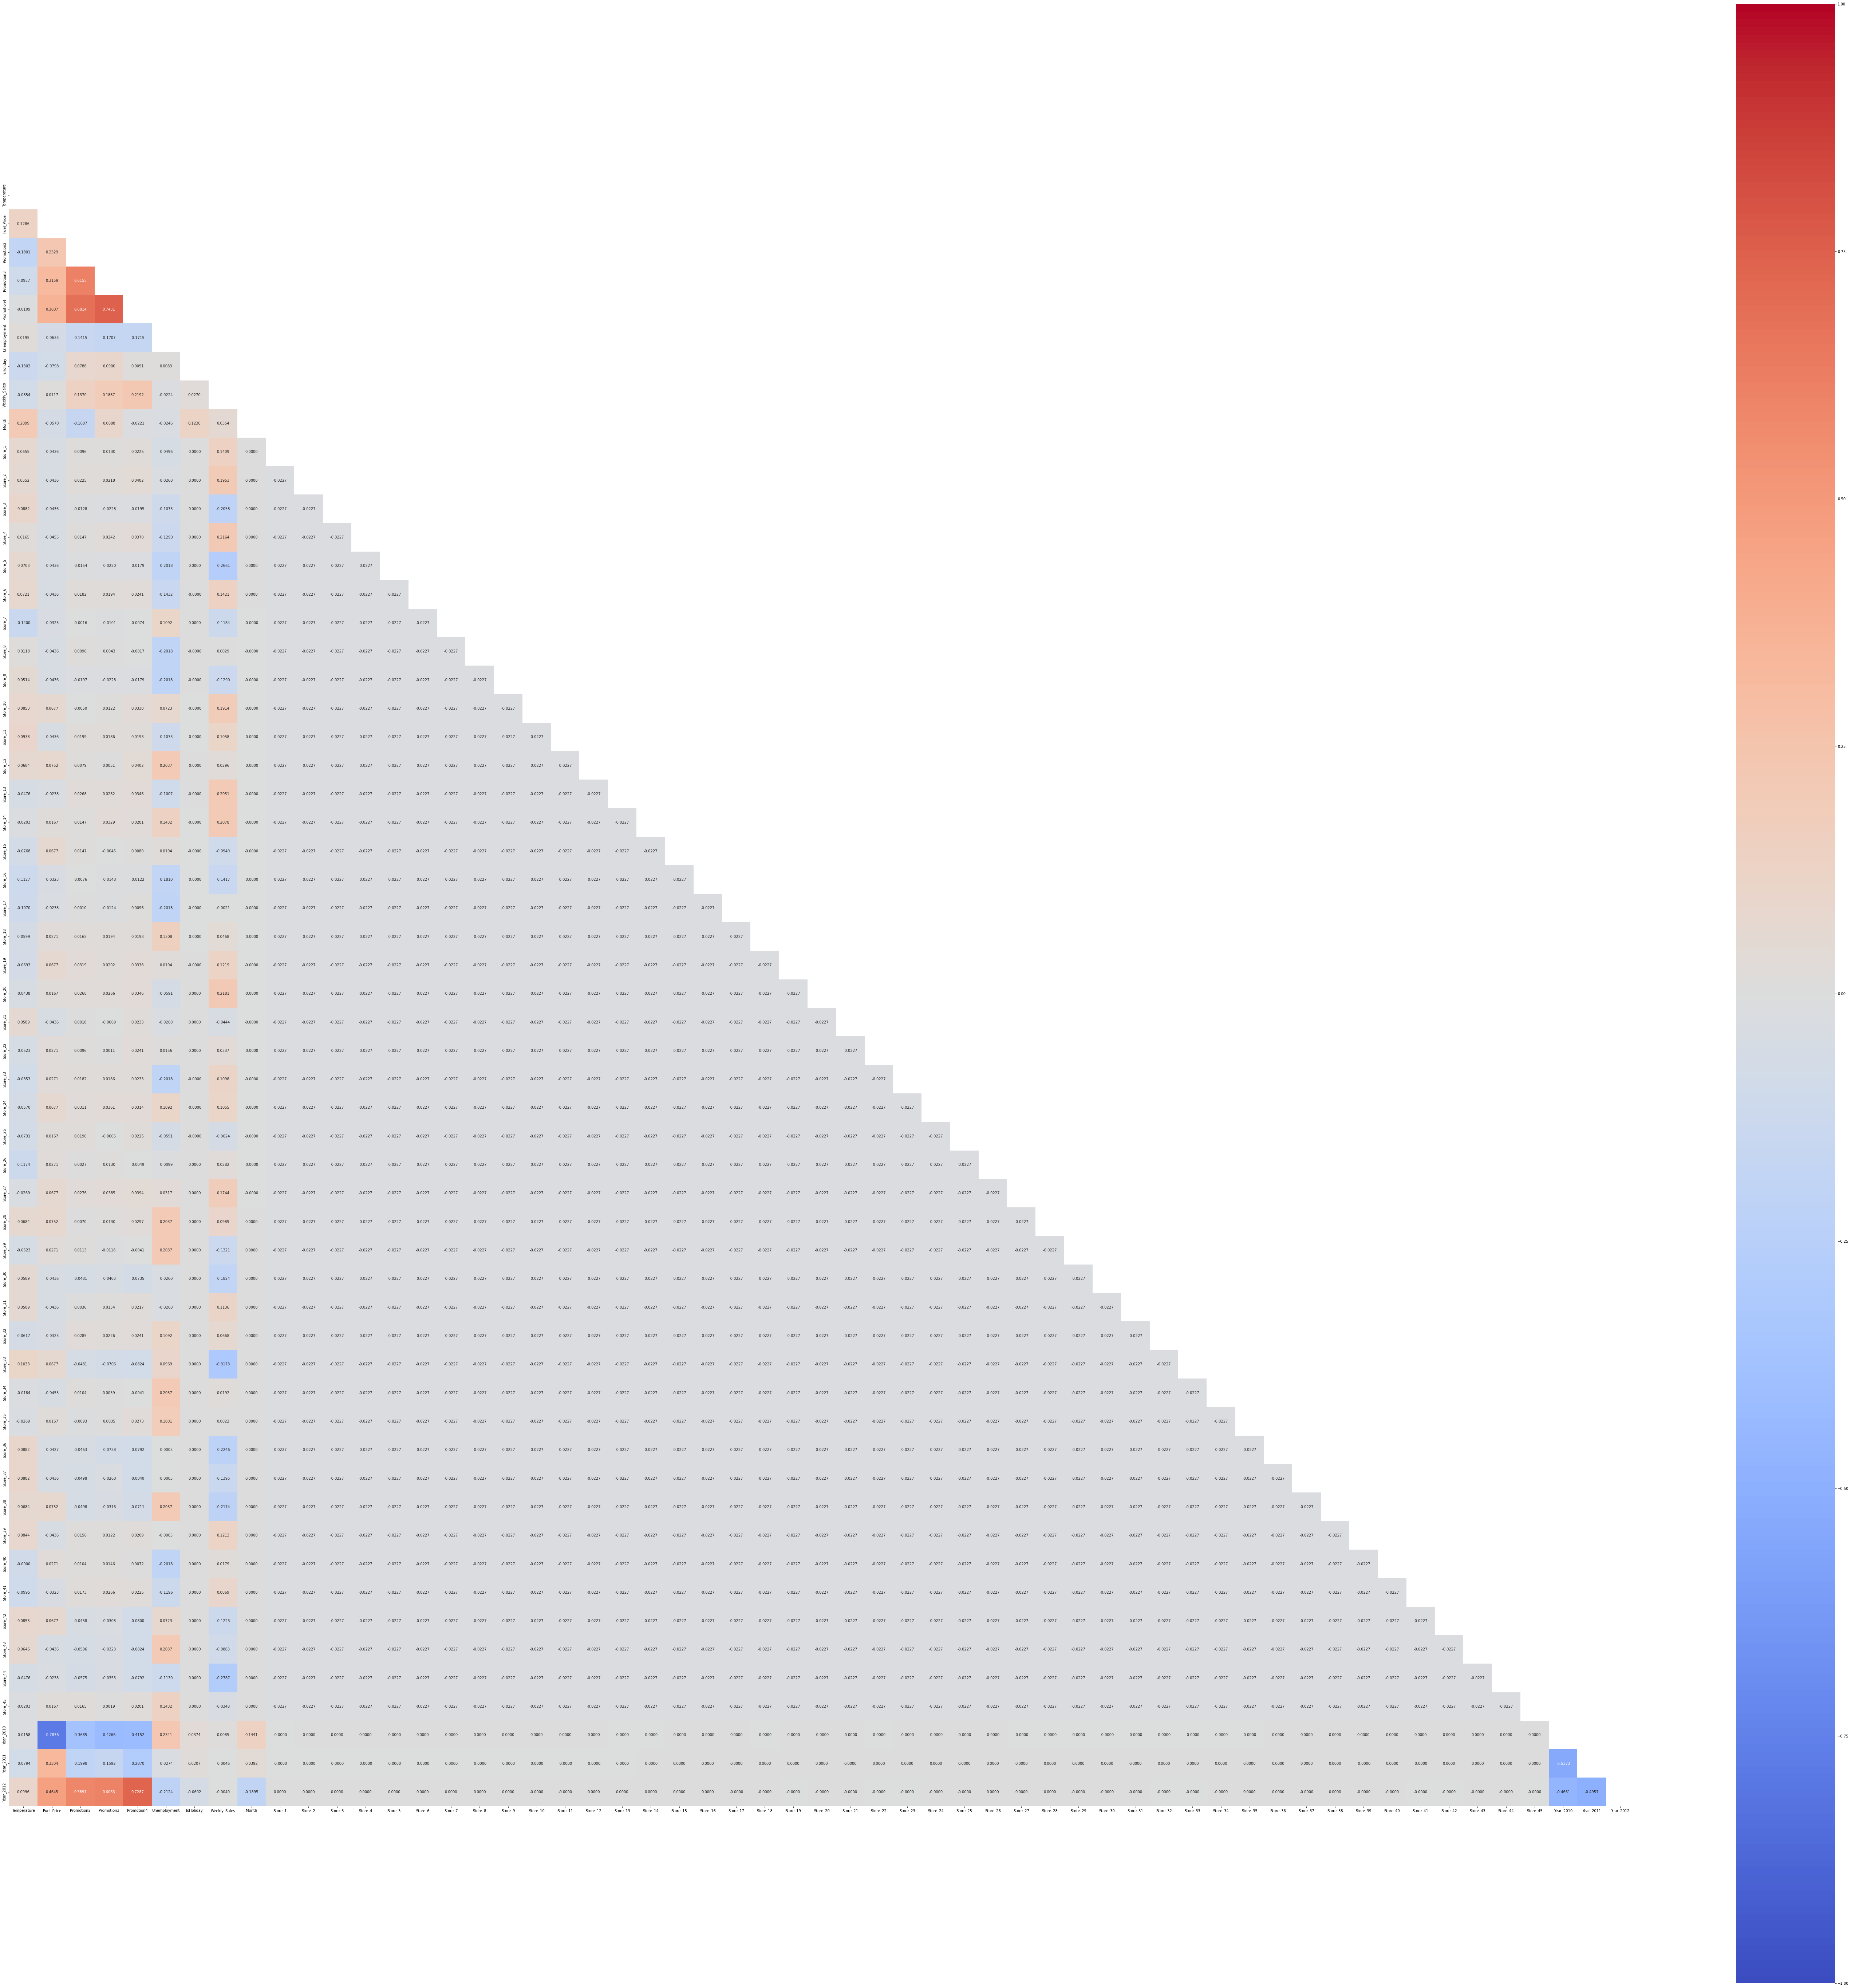

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 상관관계를 확인해보자
plt.figure(figsize=(100, 100))
# 수치형 + 타깃값
corr = df.corr()
# 마스크
mask = np.triu(corr)

sns.heatmap(corr, annot=True, fmt='.4f', vmax=1, vmin=-1, cmap='coolwarm', square=True, mask=mask)
plt.show()

In [13]:
# 데이터셋 나누기
features = df.loc[df['Weekly_Sales'].notnull()]
label = features.pop('Weekly_Sales')

X_test = df[df['Weekly_Sales'].isnull()].drop(columns='Weekly_Sales')

features.shape, label.shape, X_test.shape

((6255, 56), (6255,), (180, 56))

# 모델 및 하이퍼파라미터 최적화

## KFold

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

n = 15

kfold = KFold(n_splits=n, shuffle=True, random_state=2001) # KFold

def kfold_rmse(model):
    """KFold 교차 검증으로 모델 학습 및 검증"""
    n_iter = 0
    cv_rmse = []
    pred_test = np.zeros((test.shape[0]))

    for train_index, test_index in kfold.split(features):
        n_iter += 1

        # 학습, 검증 데이터 나누기
        X_train, X_val = features.iloc[train_index], features.iloc[test_index]
        y_train, y_val = label.iloc[train_index], label.iloc[test_index]

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0) # 모델 학습

        pred = model.predict(X_val) # 검증용 예측
        pred_test += model.predict(X_test) / n # 제출용 예측

        rmse = np.round(mean_squared_error(y_val, pred, squared=False), 4) # 평가

#         print(f'\n#{n_iter} 교차 검증 rmse : {rmse}')
        cv_rmse.append(rmse)

    rmse_avg = np.round(np.mean(cv_rmse), 4)
#     print(f'\n## 평균 검증 rmse :', rmse_avg)
    
    return pred_test, rmse_avg

## hyperopt

In [41]:
from hyperopt import hp

xgb_search_space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1), # int
                    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
                    
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)}

In [42]:
from xgboost import XGBRegressor
from hyperopt import STATUS_OK

def objective_func(search_space):
    xgb_model = XGBRegressor(random_state=2001, early_stopping_rounds=100, eval_metric='rmse', n_jobs=-1,
                             
                             n_estimators=1000, # int
                             max_depth=int(search_space['max_depth']), # int
                             min_child_weight=search_space['min_child_weight'],
                             
                             learning_rate=search_space['learning_rate'])
    
    xgb_pred, rmse_score = kfold_rmse(xgb_model)
    
    return {'loss' : rmse_score, 'status' : STATUS_OK}

In [43]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func, space=xgb_search_space, algo=tpe.suggest,
            max_evals=50, trials=trial_val, rstate=np.random.default_rng(seed=42))
best

100%|████████████████████████████████████████████████████████████| 50/50 [26:15<00:00, 31.51s/trial, best loss: 0.0717]


## 모델

In [45]:
xgb_model = XGBRegressor(random_state=2001, early_stopping_rounds=100, eval_metric='rmse', n_jobs=-1,
                         n_estimators=1000, # int
                         learning_rate=best['learning_rate'],

                         max_depth=int(best['max_depth']),
                         min_child_weight=best['min_child_weight']
                        )

## 예측

In [46]:
xgb_pred, rmse_score = kfold_rmse(xgb_model)

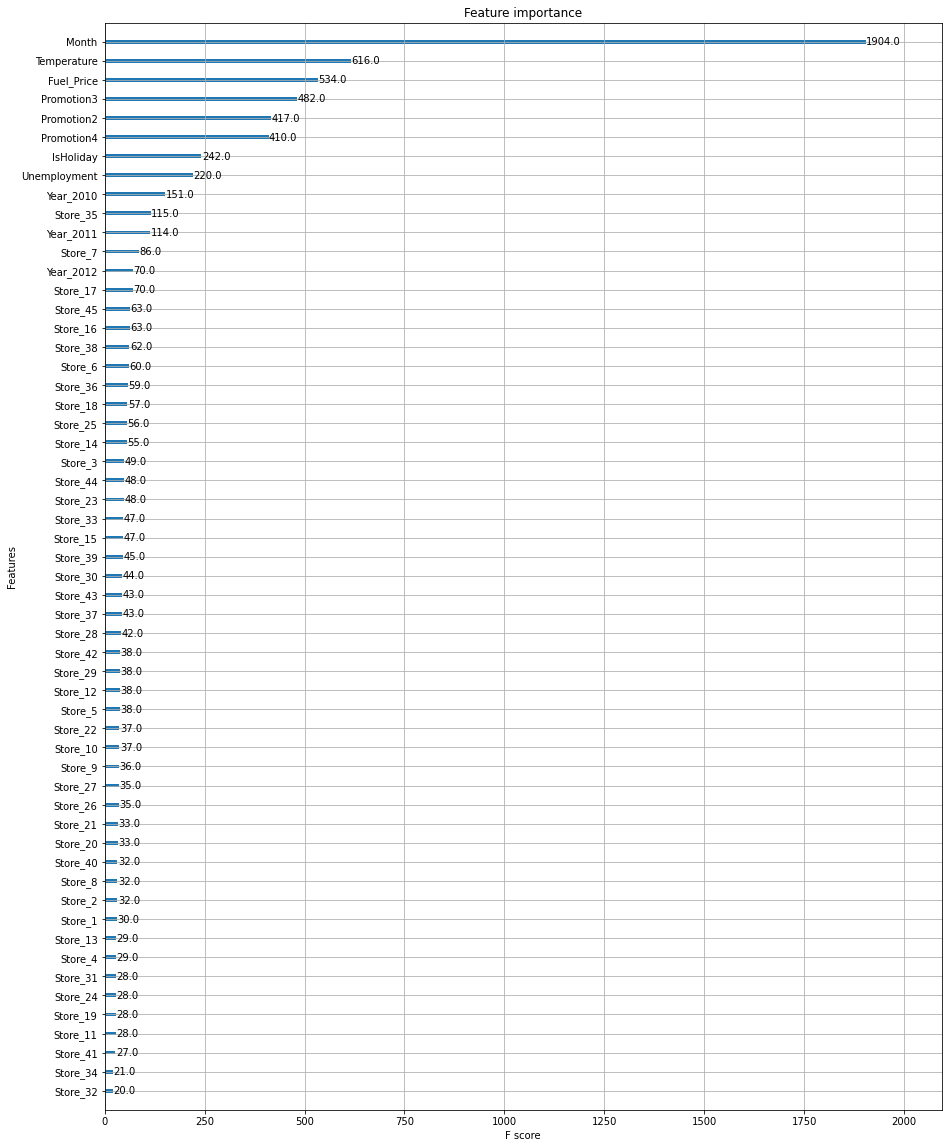

In [47]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(15, 20))
plot_importance(xgb_model, ax=ax)
plt.show()

# 제출

In [48]:
def make_submit_csv(model, pred):
    """제출 파일 만들기"""
    submission['Weekly_Sales'] = np.expm1(pred)
    submission.to_csv(data_path + f'submission_{model}_{rmse_score}.csv', index=False)

In [49]:
# XGBRegressor
make_submit_csv('xgb', xgb_pred) 